In [1]:
# !unzip /content/animals.zip

Archive:  /content/animals.zip
   creating: animals/
  inflating: animals/dog.png         
  inflating: __MACOSX/animals/._dog.png  
  inflating: animals/rabbit.png      
  inflating: __MACOSX/animals/._rabbit.png  
  inflating: animals/turtle.png      
  inflating: __MACOSX/animals/._turtle.png  
  inflating: animals/.DS_Store       
  inflating: __MACOSX/animals/._.DS_Store  
  inflating: animals/elephant.png    
  inflating: __MACOSX/animals/._elephant.png  
  inflating: animals/rat.png         
  inflating: __MACOSX/animals/._rat.png  
  inflating: animals/octopus.png     
  inflating: __MACOSX/animals/._octopus.png  
  inflating: animals/tiger.png       
  inflating: __MACOSX/animals/._tiger.png  
  inflating: animals/cow.png         
  inflating: __MACOSX/animals/._cow.png  
  inflating: animals/cheetah.png     
  inflating: __MACOSX/animals/._cheetah.png  
  inflating: animals/penguin.png     
  inflating: __MACOSX/animals/._penguin.png  
  inflating: animals/cat.png         
  

Import necessary Libraries

In [3]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import fnmatch
import cv2


from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout, Concatenate, Reshape
# from tensorflow.keras.layers.core import Reshape

print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.9.1


In [ ]:
def multibox_prior(X, sizes, ratios):
    in_height, in_width = X.shape[-3:-1]
    num_sizes, num_ratios = len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = tf.Variable(sizes)
    ratio_tensor = tf.Variable(ratios)
    # Offsets are required to move the anchor to the center of a pixel. Since
    # a pixel has height=1 and width=1, we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y axis
    steps_w = 1.0 / in_width  # Scaled steps in x axis
    # print("steps_h, steps_w", steps_h, steps_w)

    # Generate all center points for the anchor boxes
    center_h = (tf.range(in_height, dtype=tf.float32) + offset_h) * steps_h
    center_w = (tf.range(in_width, dtype=tf.float32) + offset_w) * steps_w
    shift_y, shift_x = tf.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
    # print("center_h, center_w", center_h, center_w)
    # print("shift_y, shift_x", shift_y, shift_x)

    # Generate `boxes_per_pixel` number of heights and widths that are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    w = tf.concat((size_tensor * tf.sqrt(ratio_tensor[0]), sizes[0] * tf.sqrt(ratio_tensor[1:])), axis=0) * in_height / in_width  # Handle rectangular inputs
    h = tf.concat((size_tensor / tf.sqrt(ratio_tensor[0]), sizes[0] / tf.sqrt(ratio_tensor[1:])), axis=0)
    # print(w, h)
    # Divide by 2 to get half height and half width
    # print(type(tf.stack((-w, -h, w, h)).T.numpy()))
    # return
    anchor_manipulations = np.tile(tf.stack((-w, -h, w, h), axis=0).numpy(), in_height * in_width) / 2
    anchor_manipulations = anchor_manipulations.T
    # print('anchor_manipulations: ', anchor_manipulations.shape)
    # print(anchor_manipulations)
    # Each center point will have `boxes_per_pixel` number of anchor boxes, so
    # generate a grid of all anchor box centers with `boxes_per_pixel` repeats
    # print('outgrid: ', tf.stack([shift_x, shift_y, shift_x, shift_y], axis=1).numpy().repeat(boxes_per_pixel, 0))
    out_grid = tf.stack([shift_x, shift_y, shift_x, shift_y], axis=1).numpy().repeat(boxes_per_pixel, 0)
    output = out_grid + anchor_manipulations
    print('output: ', output.shape)
    # print(output)
    return tf.expand_dims(output, 0)

In [ ]:
## TODO: check for working

def box_iou(boxes1, boxes2):
    """Compute pairwise IoU across two lists of anchor or bounding boxes."""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # Shape of `boxes1`, `boxes2`, `areas1`, `areas2`: (no. of boxes1, 4),
    # (no. of boxes2, 4), (no. of boxes1,), (no. of boxes2,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # Shape of `inter_upperlefts`, `inter_lowerrights`, `inters`: (no. of
    # boxes1, no. of boxes2, 2)
    inter_upperlefts = tf.math.maximum(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = tf.math.minimum(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).numpy().clip(min=0)
    # print(inters)
    # Shape of `inter_areas` and `union_areas`: (no. of boxes1, no. of boxes2)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

In [ ]:
def assign_anchor_to_bbox(ground_truth, anchors, iou_threshold=0.4):
    """Assign closest ground-truth bounding boxes to anchor boxes."""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # Element x_ij in the i-th row and j-th column is the IoU of the anchor
    # box i and the ground-truth bounding box j
    jaccard = box_iou(anchors, ground_truth)
    print('jaccard: ', jaccard)
    # Initialize the tensor to hold the assigned ground-truth bounding box for
    # each anchor
    anchors_bbox_map = tf.fill((num_anchors,), -1)
    print('anchors_bbox_map: ', anchors_bbox_map)
    # Assign ground-truth bounding boxes according to the threshold
    # print(tf.math.reduce_max(jaccard, axis=1))
    
    max_ious = tf.math.reduce_max(jaccard, axis=1)
    indices = tf.math.argmax(jaccard, axis=1)
    print('max_ious, indices: ', max_ious, indices)
    anc_i = tf.where(max_ious >= iou_threshold).reshape(-1)
    print('anc_i: ', anc_i)
    box_j = indices[max_ious >= iou_threshold]
    print('box_j: ', box_j)
    anchors_bbox_map_np = np.array(anchors_bbox_map)
    anchors_bbox_map_np[np.array(anc_i[:])] = box_j
    print('anchors_bbox_map: ', anchors_bbox_map_np)
    col_discard = tf.fill((num_anchors,), -1)
    row_discard = tf.fill((num_gt_boxes,), -1)
    print('row_discard, col_discard: ', row_discard, col_discard)
    jaccard = np.array(jaccard)
    for i in range(num_gt_boxes):
        max_idx = tf.math.argmax(jaccard[:, i])  # Find the largest IoU
        # print('max_idx: ', max_idx)
        box_idx = i
        anc_idx = max_idx
        print('box_idx, anc_idx: ', box_idx, anc_idx)
        anchors_bbox_map_np[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    # print('jaccard: ', jaccard)
    return tf.convert_to_tensor(anchors_bbox_map_np)

In [ ]:
def box_corner_to_center(cords):
    try:
        ret = cords.numpy()
    except:
        ret = np.copy(cords)
    ret[:, 0] = cords[:, 0] + (cords[:, 2] - cords[:, 0]) / 2
    ret[:, 1] = cords[:, 1] + (cords[:, 3] - cords[:, 1]) / 2
    ret[:, 2] = cords[:, 2] - cords[:, 0]
    ret[:, 3] = cords[:, 3] - cords[:, 1]
    return tf.convert_to_tensor(ret)

In [ ]:
def box_center_to_corner(cords):
    try:
        ret = cords.numpy()
    except:
        ret = np.copy(cords)
    ret[:, 0] = cords[:, 0] - cords[:, 2] / 2
    ret[:, 1] = cords[:, 1] - cords[:, 3] / 2
    ret[:, 2] = ret[:, 2] + ret[:, 0]
    ret[:, 3] = ret[:, 3] + ret[:, 1]
    return tf.convert_to_tensor(ret)

In [ ]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    print("offset_boxes", anchors.shape, assigned_bb.shape)
    print(assigned_bb, assigned_bb)
    """Transform for anchor box offsets."""
    # change anchors to yolo form (cx, cy, width, height)
    c_anc = box_corner_to_center(anchors)
    print('c_anc: ', c_anc)
    # change bbox to yolo form (cx, cy, width, height)
    c_assigned_bb = box_corner_to_center(assigned_bb)
    print('c_assigned_bb: ', c_assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * tf.math.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = tf.concat([offset_xy, offset_wh], axis=1)
    return offset

In [ ]:
def multibox_target(anchors, labels):
    """Label anchor boxes using ground-truth bounding boxes."""
    batch_size, anchors = labels.shape[0], anchors[0]
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(label[:, 1:], anchors)
        print('anchors_bbox_map: ', anchors_bbox_map)
        bbox_mask = (anchors_bbox_map >= 0).numpy().repeat(4, 0).reshape(-1, 4).astype('float16')
        print('bbox_mask: ', bbox_mask)
        # Initialize class labels and assigned bounding box coordinates with
        # zeros
        class_labels = tf.zeros(num_anchors)
        assigned_bb = tf.zeros((num_anchors, 4))
        print('class_labels, assigned_bb: ', class_labels, assigned_bb)
        # Label classes of anchor boxes using their assigned ground-truth
        # bounding boxes. If an anchor box is not assigned any, we label its
        # class as background (the value remains zero)
        indices_true = tf.where(anchors_bbox_map >= 0)
        print('indices_true: ', indices_true)
        bb_idx = anchors_bbox_map[indices_true]
        print('bb_idx: ', bb_idx)
        # print(' class_labels: ', label[bb_idx, 0] + 1)
        class_labels = class_labels.numpy()
        class_labels[np.array(indices_true)] = label[bb_idx, 0] + 1
        assigned_bb = assigned_bb.numpy()
        assigned_bb[np.array(indices_true)] = label[bb_idx, 1:]
        print('class_labels, assigned_bb after: ', class_labels, assigned_bb)
        # Offset transformation
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        print('offset: ', offset)
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = tf.stack(batch_offset)
    bbox_mask = tf.stack(batch_mask)
    class_labels = tf.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

In [ ]:
def offset_inverse(anchors, offset_preds):
    """Predict bounding boxes based on anchor boxes with predicted offsets."""
    anc = box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = tf.math.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = tf.concat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = box_center_to_corner(pred_bbox)
    return predicted_bbox

In [ ]:

def nms(boxes, scores, iou_threshold):
    """Sort confidence scores of predicted bounding boxes."""
    B = tf.argsort(scores, axis=-1, direction='DESCENDING')
    keep = []  # Indices of predicted bounding boxes that will be kept
    while B.numpy().size > 0:
        i = B[0]
        keep.append(i)
        if B.numpy().size == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = tf.where(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return tf.convert_to_tensor(keep)

In [ ]:

def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """Predict bounding boxes using non-maximum suppression."""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors[0]
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        # conf, class_id = torch.max(cls_prob[1:], 0)
        conf = tf.math.reduce_max(cls_prob[1:], axis=0)
        class_id = tf.math.argmax(cls_prob[1:], axis=0)
        print('conf, class_id: ', conf, class_id)
        predicted_bb = offset_inverse(anchors, offset_pred)
        print('predicted_bb: ', predicted_bb)
        keep = nms(predicted_bb, conf, nms_threshold)
        print('keep: ', keep)
        # Find all non-`keep` indices and set the class to background
        all_idx = tf.range(num_anchors)
        combined = tf.concat((keep, all_idx), axis=0)
        print('combined: ', combined)
        uniques, counts = np.unique(combined, return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = tf.concat((keep, non_keep), axis=0)
        print('all_id_sorted: ', all_id_sorted)
        class_id_np = class_id.numpy()
        class_id_np[non_keep] = -1
        print('class_id_np: ', class_id_np)
        class_id_np = class_id_np[all_id_sorted.numpy()]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # Here `pos_threshold` is a threshold for positive (non-background)
        # predictions
        
        below_min_idx = (conf < pos_threshold)
        class_id_np[below_min_idx.numpy()] = -1
        
        conf = conf.numpy()
        conf[below_min_idx.numpy()] = 1 - conf[below_min_idx.numpy()]
        
        conf = tf.convert_to_tensor(conf, dtype=tf.float64)
        class_id_np = tf.convert_to_tensor(class_id_np, dtype=tf.float64)
        
        print(class_id_np, conf, predicted_bb)
        pred_info = tf.concat((tf.expand_dims(class_id_np, 1), tf.expand_dims(conf, 1), predicted_bb), axis=1)
        out.append(pred_info)
    return tf.stack(out)

Define Bounding Boxes of Animals at size 72 X 72

In [313]:
animals_boxes = {
    'cat': [3, 68, 14, 57],
    'cheetah': [0, 70, 20, 57],
    'cock': [10, 61, 10, 62],
    'cow': [4, 66, 19, 58],
    'dog': [4, 64, 11, 63],
    'elephant': [3, 67, 15, 59],
    'fish': [11, 65, 15, 61],
    'goat': [4, 65, 11, 64],
    'monkey': [6, 66, 8, 63],
    'octopus': [7, 65, 9, 59],
    'penguin': [12, 60, 4, 64],
    'rabbit': [7, 64, 9, 58],
    'rat': [4, 68, 20, 63],
    'tiger': [3, 68, 22, 57],
    'turtle': [4, 67, 14, 57]
}

In [314]:
for key in animals_boxes.keys():
    animals_boxes[key] = np.array(animals_boxes[key])/72

In [315]:
animals_boxes

{'cat': array([0.04166667, 0.94444444, 0.19444444, 0.79166667]),
 'cheetah': array([0.        , 0.97222222, 0.27777778, 0.79166667]),
 'cock': array([0.13888889, 0.84722222, 0.13888889, 0.86111111]),
 'cow': array([0.05555556, 0.91666667, 0.26388889, 0.80555556]),
 'dog': array([0.05555556, 0.88888889, 0.15277778, 0.875     ]),
 'elephant': array([0.04166667, 0.93055556, 0.20833333, 0.81944444]),
 'fish': array([0.15277778, 0.90277778, 0.20833333, 0.84722222]),
 'goat': array([0.05555556, 0.90277778, 0.15277778, 0.88888889]),
 'monkey': array([0.08333333, 0.91666667, 0.11111111, 0.875     ]),
 'octopus': array([0.09722222, 0.90277778, 0.125     , 0.81944444]),
 'penguin': array([0.16666667, 0.83333333, 0.05555556, 0.88888889]),
 'rabbit': array([0.09722222, 0.88888889, 0.125     , 0.80555556]),
 'rat': array([0.05555556, 0.94444444, 0.27777778, 0.875     ]),
 'tiger': array([0.04166667, 0.94444444, 0.30555556, 0.79166667]),
 'turtle': array([0.05555556, 0.93055556, 0.19444444, 0.791666

In [322]:
animals = {}
filenames = fnmatch.filter(os.listdir('animals'), '*.png')

# temp['name'] = 'background'
# temp['file'] = 'background.none' 
# temp['boxes'] = [0,0,0,0]
# animals[0] = temp

for idx, filename in enumerate(filenames):
    temp = {}  
    temp['name'] = filename.split('.')[0]
    temp['file'] = filename 
    temp['boxes'] = animals_boxes[filename.split('.')[0]]
    animals[idx] = temp

In [323]:
animals

{0: {'name': 'cat',
  'file': 'cat.png',
  'boxes': array([0.04166667, 0.94444444, 0.19444444, 0.79166667])},
 1: {'name': 'cheetah',
  'file': 'cheetah.png',
  'boxes': array([0.        , 0.97222222, 0.27777778, 0.79166667])},
 2: {'name': 'cock',
  'file': 'cock.png',
  'boxes': array([0.13888889, 0.84722222, 0.13888889, 0.86111111])},
 3: {'name': 'cow',
  'file': 'cow.png',
  'boxes': array([0.05555556, 0.91666667, 0.26388889, 0.80555556])},
 4: {'name': 'dog',
  'file': 'dog.png',
  'boxes': array([0.05555556, 0.88888889, 0.15277778, 0.875     ])},
 5: {'name': 'elephant',
  'file': 'elephant.png',
  'boxes': array([0.04166667, 0.93055556, 0.20833333, 0.81944444])},
 6: {'name': 'fish',
  'file': 'fish.png',
  'boxes': array([0.15277778, 0.90277778, 0.20833333, 0.84722222])},
 7: {'name': 'goat',
  'file': 'goat.png',
  'boxes': array([0.05555556, 0.90277778, 0.15277778, 0.88888889])},
 8: {'name': 'monkey',
  'file': 'monkey.png',
  'boxes': array([0.08333333, 0.91666667, 0.11111

In [324]:
# The total number of classes we have
N_CLASSES = len(animals) + 1 # one extra for background

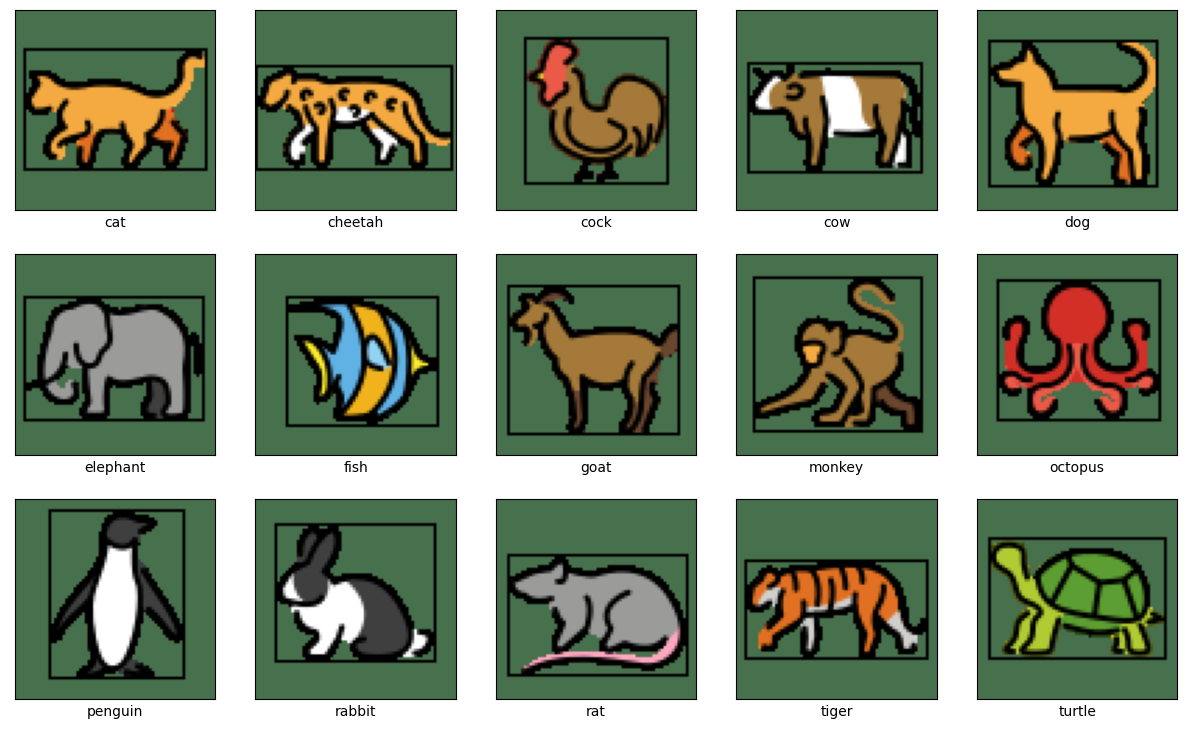

In [325]:
plt.figure(figsize=(15, 9))

for i, (j, e) in enumerate(animals.items()):
    plt.subplot(3, 5, i + 1)
    image = cv2.imread(os.path.join('animals', e['file']))
    # image = Image.open(os.path.join('animals', e['file']))
    image = Image.fromarray(image[:,:,::-1])
    draw = ImageDraw.Draw(image)
    anml = animals[i]
#     print(anml['boxes'])
    draw.rectangle((anml['boxes'][0] * 72, anml['boxes'][2]*72, anml['boxes'][1]*72, anml['boxes'][3]*72), outline='black', width=1)
    plt.imshow(image)
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [327]:
import random
for class_id, values in animals.items():
    png_file = Image.open(os.path.join('animals', values['file'])).convert('RGBA')
    # png_file = cv2.imread(os.path.join('animals', values['file']), cv2.IMREAD_UNCHANGED)
    # print(png_file[0,0,:])
    # print(png_file)
    # png_file.load()
    # print(png_file)
#     new_size = int(png_file.size[0] * (1 + random.randint(0, 100)/100)) 
    # new_size = 72
    # new_file = Image.new("RGBA", (72, 72), (255, 255, 255))
    # new_file.paste(png_file, mask=png_file.split()[3])
    # new_file1 = new_file.resize((new_size, new_size), Image.ANTIALIAS)
    # animals[class_id]['image'] = new_file1
    animals[class_id]['image'] = png_file


In [328]:
animals

{0: {'name': 'cat',
  'file': 'cat.png',
  'boxes': array([0.04166667, 0.94444444, 0.19444444, 0.79166667]),
  'image': <PIL.Image.Image image mode=RGBA size=72x72>},
 1: {'name': 'cheetah',
  'file': 'cheetah.png',
  'boxes': array([0.        , 0.97222222, 0.27777778, 0.79166667]),
  'image': <PIL.Image.Image image mode=RGBA size=72x72>},
 2: {'name': 'cock',
  'file': 'cock.png',
  'boxes': array([0.13888889, 0.84722222, 0.13888889, 0.86111111]),
  'image': <PIL.Image.Image image mode=RGBA size=72x72>},
 3: {'name': 'cow',
  'file': 'cow.png',
  'boxes': array([0.05555556, 0.91666667, 0.26388889, 0.80555556]),
  'image': <PIL.Image.Image image mode=RGBA size=72x72>},
 4: {'name': 'dog',
  'file': 'dog.png',
  'boxes': array([0.05555556, 0.88888889, 0.15277778, 0.875     ]),
  'image': <PIL.Image.Image image mode=RGBA size=72x72>},
 5: {'name': 'elephant',
  'file': 'elephant.png',
  'boxes': array([0.04166667, 0.93055556, 0.20833333, 0.81944444]),
  'image': <PIL.Image.Image image mo

In [339]:
def create_example():
    image = Image.new("RGB", (320, 320), (255, 255, 255))
    n_objects = np.random.randint(1, 5)
    class_ids = []
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    cords = []
    
    for _ in range(n_objects):
        class_id = np.random.randint(0, N_CLASSES-1)
        size = np.random.randint(50, 160)
        animal_image = animals[class_id]['image'].resize((size, size), Image.LANCZOS)
        # print(np.array(animal_image).shape)
        row = np.random.randint(0, 320-size)
        col = np.random.randint(0, 320-size)
        image.paste(animal_image, (col, row), mask=animal_image.split()[3])
        xmin = col+(animals[class_id]['boxes'][0]*size)
        xmax = col+(animals[class_id]['boxes'][1]*size)
        ymin = row+(animals[class_id]['boxes'][2]*size)
        ymax = row+(animals[class_id]['boxes'][3]*size)
        
        one_hot_class = [0 for x in range(N_CLASSES)]
        one_hot_class[class_id] = 1
        class_ids.append(one_hot_class)
        
        cords.append([xmin/320, xmax/320, ymin/320, ymax/320])
        # xmins.append(xmin/320)
        # xmaxs.append(xmax/320)
        # ymins.append(ymin/320)
        # ymaxs.append(ymax/320)
    return image, class_ids, cords


C:\Users\Rehan Zafar\AppData\Local\Temp\ipykernel_13692\1648068131.py:14: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  animal_image = animals[class_id]['image'].resize((size, size), Image.LANCZOS)


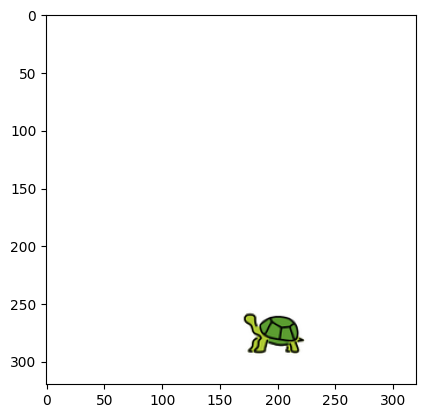

In [340]:
image, class_ids, bboxes = create_example()
# plt.xlabel(size)
plt.imshow(image)

In [341]:
class_ids

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]

In [342]:
def plot_bounding_box(image, gt_bbox, pred_bbox=[], norm=False):
    # print(gt_bbox)
    if norm:
        image *= 255
        image = image.astype('uint8')

    try:
        draw = ImageDraw.Draw(image)
    except:
        image = Image.fromarray(image)
        draw = ImageDraw.Draw(image)
        
    for i in range(len(gt_bbox)):
        xmin, xmax, ymin, ymax = gt_bbox[i]
        xmin *= 320
        xmax *= 320
        ymin *= 320
        ymax *= 320

        draw.rectangle((xmin, ymin, xmax, ymax), outline='green', width=1)

    if len(pred_bbox) == 4:
        print(gt_bbox, pred_bbox)
        xmin, xmax, ymin, ymax = pred_bbox
        xmin *= 320
        xmax *= 320
        ymin *= 320
        ymax *= 320

        draw.rectangle((xmin, ymin, xmax, ymax), outline='red', width=1)
    return image

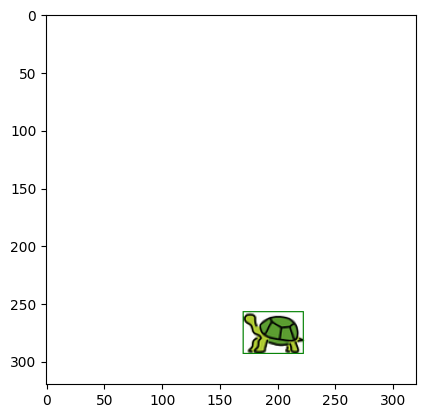

In [343]:

image = plot_bounding_box(image, gt_bbox=bboxes)
plt.imshow(image)
# plt.title(animals[class_id]['name'])
plt.show()

In [344]:
# Generate Data
def data_generator(batch_size=16):
    while True:
        x_batch = np.zeros((batch_size, 320, 320, 3))

        for i in range(0, batch_size):
            image, class_ids, bboxes = create_example()
            
            bbox_batch = np.zeros((batch_size, len(bboxes), 4))
            y_batch = np.zeros((batch_size, len(bboxes), N_CLASSES))
            
            x_batch[i] = np.array(image)/255.
            y_batch[i] = np.array(class_ids)
            # print(np.array(bboxes).shape)
            bbox_batch[i] = np.array(bboxes)
        yield {'image': x_batch}, {'class_out': y_batch, 'box_out': bbox_batch}


{'class_out': array([[[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]]]), 'box_out': array([[[0.52934028, 0.68871528, 0.28177083, 0.41753472],
        [0.13993056, 0.56510417, 0.40217014, 0.66961806],
        [0.071875  , 0.434375  , 0.575     , 0.8875    ],
        [0.24743924, 0.53194444, 0.51367188, 0.75824653]]])}


C:\Users\Rehan Zafar\AppData\Local\Temp\ipykernel_13692\1648068131.py:14: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  animal_image = animals[class_id]['image'].resize((size, size), Image.LANCZOS)


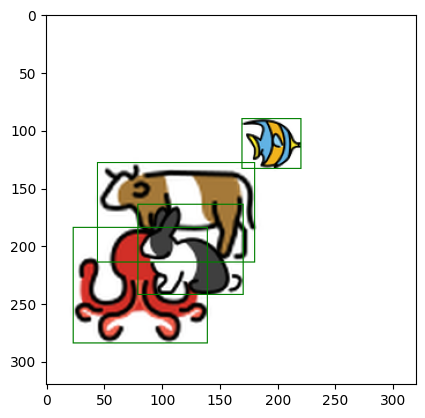

In [345]:
example, label = next(data_generator(1))
image = example['image'][0]
# class_id = np.argmax(label['class_out'][0])
bbox = label['box_out'][0]
print(label)

image = plot_bounding_box(image, label['box_out'][0], norm=True)
plt.imshow(image)
# plt.title(animals[class_id]['name'])

In [351]:
# input_ = Input(shape=(320, 320, 3), name='image')


# conv2d_1 = Conv2D(16, 3, activation='relu', name='conv2d_1')(input_)
# maxpool2d_1 = MaxPool2D(2, name='maxpool2d_1')(conv2d_1)


# conv2d_2 = Conv2D(32, 3, activation='relu', name='conv2d_2')(maxpool2d_1)
# maxpool2d_2 = MaxPool2D(2, name='maxpool2d_2')(conv2d_2)


# conv2d_3 = Conv2D(64, 3, activation='relu', name='conv2d_3')(maxpool2d_2)
# maxpool2d_3 = MaxPool2D(2, name='maxpool2d_3')(conv2d_3)


# conv2d_4 = Conv2D(128, 3, activation='relu', name='conv2d_4')(maxpool2d_3)
# maxpool2d_4 = MaxPool2D(2, name='maxpool2d_4')(conv2d_4)


# conv2d_5 = Conv2D(256, 3, activation='relu', name='conv2d_5')(maxpool2d_4)
# maxpool2d_5 = MaxPool2D(2, name='maxpool2d_5')(conv2d_5)


# conv2d_6 = Conv2D(256, 3, activation='relu', name='conv2d_6')(maxpool2d_5)

# maxpool2d_6 = MaxPool2D(2, name='maxpool2d_6')(conv2d_6) # 3x3x256 output
  
# conv2d_7 = Conv2D(256, 2, activation='relu', name='conv2d_7')(maxpool2d_6) # 2x2x256 output

# conv2d_8 = Conv2D(512, 2, activation='relu', name='conv2d_8')(conv2d_7) # 1x1x512 output
    

# flatten_3x3 = Flatten(name='flatten_3x3')(maxpool2d_6)
# flatten_2x2 = Flatten(name='flatten_2x2')(conv2d_7)
# flatten_1x1 = Flatten(name='flatten_1x1')(conv2d_8)



# # 3x3 grid outputs
# dense_3x3_1 = Dense(1024, activation='relu', name='dense_3x3_1')(flatten_3x3)
# class_out_3x3 = Dense(144, activation='softmax', name='class_out_3x3')(dense_3x3_1)
# box_out_3x3 = Dense(36, name='box_out_3x3')(dense_3x3_1)

# class_out_3x3_reshape = Reshape((9, 16), name='class_out_3x3_reshape')(class_out_3x3)
# box_out_3x3_reshape = Reshape((9, 4), name='box_out_3x3_reshape')(box_out_3x3)



# # 2x2 grid outputs
# dense_2x2_1 = Dense(512, activation='relu', name='dense_2x2_1')(flatten_2x2)
# class_out_2x2 = Dense(64, activation='softmax', name='class_out_2x2')(dense_2x2_1)
# box_out_2x2 = Dense(16, name='box_out_2x2')(dense_2x2_1)

# class_out_2x2_reshape = Reshape((4, 16), name='class_out_2x2_reshape')(class_out_2x2)
# box_out_2x2_reshape = Reshape((4, 4), name='box_out_2x2_reshape')(box_out_2x2)
    
    
    
# # 1x1 grid outputs
# dense_1x1_1 = Dense(128, activation='relu', name='dense_1x1_1')(flatten_1x1)
# class_out_1x1 = Dense(16, activation='softmax', name='class_out_1x1')(dense_1x1_1)
# box_out_1x1 = Dense(4, name='box_out_1x1')(dense_1x1_1)

# class_out_1x1_reshape = Reshape((1, 16), name='class_out_1x1_reshape')(class_out_1x1)
# box_out_1x1_reshape = Reshape((1, 4), name='box_out_1x1_reshape')(box_out_1x1)
    
    
  
# class_out = Concatenate(axis=1, name='class_out')([class_out_3x3_reshape, class_out_2x2_reshape, class_out_1x1_reshape])
# bbox_out = Concatenate(axis=1, name='bbox_out')([box_out_3x3_reshape, box_out_2x2_reshape, box_out_1x1_reshape])
    
# print(bbox_out.shape)
# # x = Flatten()(conv2d_8)
# # x = Dense(256, activation='relu')(x)
# # class_out = Dense(15, activation='softmax', name='class_out')(x)
# # box_out = Dense(4, name='box_out')(x)

# model = tf.keras.models.Model(input_, [class_out, bbox_out])
# model.summary()

In [359]:
input_ = Input(shape=(320, 320, 3), name='image')


conv2d_1 = Conv2D(16, 3, activation='relu', name='conv2d_1', padding='same')(input_)
maxpool2d_1 = MaxPool2D(2, name='maxpool2d_1')(conv2d_1)


conv2d_2 = Conv2D(32, 3, activation='relu', name='conv2d_2', padding='same')(maxpool2d_1)
maxpool2d_2 = MaxPool2D(2, name='maxpool2d_2')(conv2d_2)


conv2d_3 = Conv2D(64, 3, activation='relu', name='conv2d_3', padding='same')(maxpool2d_2)
maxpool2d_3 = MaxPool2D(2, name='maxpool2d_3')(conv2d_3)


conv2d_4 = Conv2D(128, 3, activation='relu', name='conv2d_4', padding='same')(maxpool2d_3)
maxpool2d_4 = MaxPool2D(2, name='maxpool2d_4')(conv2d_4) # 20x20x128


conv2d_5 = Conv2D(256, 3, activation='relu', name='conv2d_5', padding='same')(maxpool2d_4)
maxpool2d_5 = MaxPool2D(2, name='maxpool2d_5')(conv2d_5) # 10x10x128


conv2d_6 = Conv2D(256, 3, activation='relu', name='conv2d_6', padding='same')(maxpool2d_5)

maxpool2d_6 = MaxPool2D(2, name='maxpool2d_6')(conv2d_6) # 5x5x128 output
  
conv2d_7 = Conv2D(256, 3, activation='relu', name='conv2d_7')(maxpool2d_6) # 3x3x128 output

conv2d_8 = Conv2D(512, 3, activation='relu', name='conv2d_8')(conv2d_7) # 1x1x256 output
    

class_20x20 = Conv2D(64, 3, name='class_20x20', padding='same')(maxpool2d_4)
class_20x20_reshape = Reshape((-1, 16), name='class_20x20_reshape')(class_20x20)
box_20x20 = Conv2D(16, 3, name='box_20x20', padding='same')(maxpool2d_4)
box_20x20_reshape = Flatten(name='box_20x20_reshape')(box_20x20)


class_10x10 = Conv2D(64, 3, name='class_10x10', padding='same')(maxpool2d_5)
class_10x10_reshape = Reshape((-1, 16), name='class_10x10_reshape')(class_10x10)
box_10x10 = Conv2D(16, 3, name='box_10x10', padding='same')(maxpool2d_5)
box_10x10_reshape = Flatten(name='box_10x10_reshape')(box_10x10)


class_5x5 = Conv2D(64, 3, name='class_5x5', padding='same')(maxpool2d_6)
class_5x5_reshape = Reshape((-1, 16), name='class_5x5_reshape')(class_5x5)
box_5x5 = Conv2D(16, 3, name='box_5x5', padding='same')(maxpool2d_6)
box_5x5_reshape = Flatten(name='box_5x5_reshape')(box_5x5)


class_3x3 = Conv2D(64, 3, name='class_3x3', padding='same')(conv2d_7)
class_3x3_reshape = Reshape((-1, 16), name='class_3x3_reshape')(class_3x3)
box_3x3 = Conv2D(16, 3, name='box_3x3', padding='same')(conv2d_7)
box_3x3_reshape = Flatten(name='box_3x3_reshape')(box_3x3)


class_1x1 = Conv2D(64, 3, name='class_1x1', padding='same')(conv2d_8)
class_1x1_reshape = Reshape((-1, 16), name='class_1x1_reshape')(class_1x1)
box_1x1 = Conv2D(16, 3, name='box_1x1', padding='same')(conv2d_8)
box_1x1_reshape = Flatten(name='box_1x1_reshape')(box_1x1)


# # 20x20 grid outputs
# dense_20x20_1 = Dense(256, activation='relu', name='dense_20x20_1')(flatten_20x20)
# class_out_20x20 = Dense(144, activation='softmax', name='class_out_20x20')(dense_20x20_1)
# box_out_20x20 = Dense(36, name='box_out_20x20')(dense_20x20_1)

# class_out_20x20_reshape = Reshape((9, 16), name='class_out_20x20_reshape')(class_out_20x20)
# box_out_20x20_reshape = Reshape((9, 4), name='box_out_20x20_reshape')(box_out_20x20)



# # 3x3 grid outputs
# dense_3x3_1 = Dense(256, activation='relu', name='dense_3x3_1')(flatten_3x3)
# class_out_3x3 = Dense(144, activation='softmax', name='class_out_3x3')(dense_3x3_1)
# box_out_3x3 = Dense(36, name='box_out_3x3')(dense_3x3_1)

# class_out_3x3_reshape = Reshape((9, 16), name='class_out_3x3_reshape')(class_out_3x3)
# box_out_3x3_reshape = Reshape((9, 4), name='box_out_3x3_reshape')(box_out_3x3)



# # 3x3 grid outputs
# dense_3x3_1 = Dense(256, activation='relu', name='dense_3x3_1')(flatten_3x3)
# class_out_3x3 = Dense(144, activation='softmax', name='class_out_3x3')(dense_3x3_1)
# box_out_3x3 = Dense(36, name='box_out_3x3')(dense_3x3_1)

# class_out_3x3_reshape = Reshape((9, 16), name='class_out_3x3_reshape')(class_out_3x3)
# box_out_3x3_reshape = Reshape((9, 4), name='box_out_3x3_reshape')(box_out_3x3)



# # 2x2 grid outputs
# dense_2x2_1 = Dense(512, activation='relu', name='dense_2x2_1')(flatten_2x2)
# class_out_2x2 = Dense(64, activation='softmax', name='class_out_2x2')(dense_2x2_1)
# box_out_2x2 = Dense(16, name='box_out_2x2')(dense_2x2_1)

# class_out_2x2_reshape = Reshape((4, 16), name='class_out_2x2_reshape')(class_out_2x2)
# box_out_2x2_reshape = Reshape((4, 4), name='box_out_2x2_reshape')(box_out_2x2)
    
    
    
# # 1x1 grid outputs
# dense_1x1_1 = Dense(128, activation='relu', name='dense_1x1_1')(flatten_1x1)
# class_out_1x1 = Dense(16, activation='softmax', name='class_out_1x1')(dense_1x1_1)
# box_out_1x1 = Dense(4, name='box_out_1x1')(dense_1x1_1)

# class_out_1x1_reshape = Reshape((1, 16), name='class_out_1x1_reshape')(class_out_1x1)
# box_out_1x1_reshape = Reshape((1, 4), name='box_out_1x1_reshape')(box_out_1x1)
    
    
  
class_out = Concatenate(axis=1, name='class_out')([class_20x20_reshape, class_10x10_reshape, class_5x5_reshape, class_3x3_reshape, class_1x1_reshape])
bbox_out = Concatenate(axis=1, name='bbox_out')([box_20x20_reshape, box_10x10_reshape, box_5x5_reshape, box_3x3_reshape, box_1x1_reshape])
    
print(bbox_out.shape)
# x = Flatten()(conv2d_8)
# x = Dense(256, activation='relu')(x)
# class_out = Dense(15, activation='softmax', name='class_out')(x)
# box_out = Dense(4, name='box_out')(x)

model = tf.keras.models.Model(input_, [class_out, bbox_out])
model.summary()

(None, 8560)
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 320, 320, 16  448         ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 maxpool2d_1 (MaxPooling2D)     (None, 160, 160, 16  0           ['conv2d_1[0][0]']               
                                )                                             

In [354]:
# dir(box_out_3x3_reshape)
# box_out_3x3_reshape.shape
# box_out_3x3_reshape.set_shape((9,4))

In [97]:
# class IoU(tf.keras.metrics.Metric):
#     def __init__(self, **kwargs):
#         super(IoU, self).__init__(**kwargs)

#         self.iou = self.add_weight(name='iou', initializer='zeros')
#         self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
#         self.num_ex = self.add_weight(name='num_ex', initializer='zeros')

    
#     def update_state(self, y_true, y_pred, sample_weight=None):
#         def get_box(y):
            
#             xmin, xmax, ymin, ymax = y[:, 0], y[:, 1], y[:, 2], y[:, 3]
#             xmin, xmax, ymin, ymax = xmin*320, xmax*320, ymin*320, ymax*320
#             # ratio = size/72.0
            
#             return xmin, ymin, xmax, ymax


#         def get_area(x1, y1, x2, y2):
#             return tf.math.abs(x2 - x1) * tf.math.abs(y2 - y1)
        
#         gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)
#         p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)
        
#         i_x1 = tf.maximum(gt_x1, p_x1)
#         i_x2 = tf.maximum(gt_x2, p_x2)
#         i_y1 = tf.minimum(gt_y1, p_y1)
#         i_y2 = tf.minimum(gt_y2, p_y2)
        
#         # compute the area of intersection rectangle
#         i_area = tf.maximum(0.0, i_x2 - i_x1) * tf.maximum(0.0, i_y2 - i_y1)
#         # compute the area of both the prediction and ground-truth
#         # rectangles
        
        
#         # i_area = get_area(i_x1, i_x2, i_y1, i_y2)
#         # print(gt_x2)
        
#         # gt_p = box(gt_x1, gt_y1, gt_x2, gt_y2)
#         # pred_p = box(p_x1, p_y1, p_x2, p_y2)
        
#         # intersection = gt_p.intersection(pred_p)
        
#         # i_area = intersection.area
#         u_area = get_area(gt_x1, gt_y1, gt_x2, gt_y2) + get_area(p_x1, p_y1, p_x2, p_y2) - i_area
        
#         iou = tf.math.divide(i_area, u_area)
#         print(iou)
#         self.num_ex.assign_add(1)
#         self.total_iou.assign_add(tf.reduce_mean(iou))
#         self.iou = tf.math.divide(self.total_iou, self.num_ex)

#     def result(self):
#         return self.iou

#     def reset_state(self):
#         self.iou = self.add_weight(name='iou', initializer='zeros')
#         self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
#         self.num_ex = self.add_weight(name='num_ex', initializer='zeros')


In [ ]:
def calculate_iou(y_true, y_pred):
    
    
    """
    Input:
    Keras provides the input as numpy arrays with shape (batch_size, num_columns).
    
    Arguments:
    y_true -- first box, numpy array with format [x, y, width, height, conf_score]
    y_pred -- second box, numpy array with format [x, y, width, height, conf_score]
    x any y are the coordinates of the top left corner of each box.
    
    Output: IoU of type float32. (This is a ratio. Max is 1. Min is 0.)
    
    """

    
    results = []
    
    for i in range(0,y_true.shape[0]):
    
        # set the types so we are sure what type we are using
        y_true = y_true.astype(np.float32)
        y_pred = y_pred.astype(np.float32)


        # boxTrue
        x_boxTrue_tleft = y_true[0,0]  # numpy index selection
        y_boxTrue_tleft = y_true[0,2]
        boxTrue_width = y_true[0,1] - y_true[0,0]
        boxTrue_height = y_true[0,3] - y_true[0,2]
        area_boxTrue = (boxTrue_width * boxTrue_height)

        # boxPred
        x_boxPred_tleft = y_pred[0,0]
        y_boxPred_tleft = y_pred[0,2]
        boxPred_width = y_pred[0,1] - y_pred[0,0]
        boxPred_height = y_pred[0,3] - y_pred[0,2]
        area_boxPred = (boxPred_width * boxPred_height)


        # calculate the bottom right coordinates for boxTrue and boxPred

        # boxTrue
        x_boxTrue_br = x_boxTrue_tleft + boxTrue_width
        y_boxTrue_br = y_boxTrue_tleft + boxTrue_height # Version 2 revision

        # boxPred
        x_boxPred_br = x_boxPred_tleft + boxPred_width
        y_boxPred_br = y_boxPred_tleft + boxPred_height # Version 2 revision


        # calculate the top left and bottom right coordinates for the intersection box, boxInt

        # boxInt - top left coords
        x_boxInt_tleft = np.max([x_boxTrue_tleft,x_boxPred_tleft])
        y_boxInt_tleft = np.max([y_boxTrue_tleft,y_boxPred_tleft]) # Version 2 revision

        # boxInt - bottom right coords
        x_boxInt_br = np.min([x_boxTrue_br,x_boxPred_br])
        y_boxInt_br = np.min([y_boxTrue_br,y_boxPred_br]) 

        # Calculate the area of boxInt, i.e. the area of the intersection 
        # between boxTrue and boxPred.
        # The np.max() function forces the intersection area to 0 if the boxes don't overlap.
        
        
        # Version 2 revision
        area_of_intersection = \
        np.max([0,(x_boxInt_br - x_boxInt_tleft)]) * np.max([0,(y_boxInt_br - y_boxInt_tleft)])

        iou = area_of_intersection / ((area_boxTrue + area_boxPred) - area_of_intersection)


        # This must match the type used in py_func
        iou = iou.astype(np.float32)
        
        # append the result to a list at the end of each loop
        results.append(iou)
    
    
    # return the mean IoU score for the batch
    # print('\nresults', results)
    return np.mean(results)

In [ ]:
def IoU(y_true, y_pred):
    
    iou = tf.numpy_function(calculate_iou, inp=[y_true, y_pred], Tout=tf.float32)
    return iou

In [88]:
model.compile(
    loss = {
        'class_out': 'categorical_crossentropy',
        'box_out': 'mae'
    },
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = {
        'class_out': 'accuracy',
        'box_out': IoU
    }
)

In [89]:
def test_model(model, test_datagen):
    example, label = next(test_datagen)
    x = example['image']
    y = label['class_out']
    box = label['box_out']

    pred_y, pred_box = model.predict(x)

    pred_bbox = pred_box[0]
    gt_bbox = box[0]
    print(gt_bbox, pred_bbox)
    pred_class = np.argmax(pred_y[0])
    image = x[0]

    gt_class_name = animals[np.argmax(y[0])]['name']
    pred_class_name = animals[pred_class]['name']

    # print(pred_bbox, gt_bbox)
    image = plot_bounding_box(image, gt_bbox, pred_bbox, norm=True)
    color = 'green' if gt_class_name == pred_class_name else 'red'

    plt.imshow(image)
    plt.xlabel(f'Pred: {pred_class_name}', color=color)
    plt.ylabel(f'GT: {gt_class_name}', color=color)
    plt.xticks([])
    plt.yticks([])

In [102]:
example, label = next(data_generator(1))
x = example['image']

pred_y, pred_box = model.predict(x)
print(pred_y, pred_box)

type(pred_y)

1/1 [==============================] - 0s 63ms/step
[[[0.00681559 0.00690986 0.00724749 0.00682677 0.00661932 0.00685969
   0.00686193 0.00686942 0.006767   0.00745156 0.00687934 0.00711405
   0.00672121 0.00769139 0.00665064 0.00741798]
  [0.00681025 0.00661497 0.00762406 0.00687752 0.00682902 0.00665857
   0.0066473  0.00672671 0.00686393 0.00736981 0.0070226  0.00632389
   0.0069756  0.00702757 0.00742457 0.00683396]
  [0.0069234  0.00678577 0.00691162 0.00620439 0.00681494 0.00681624
   0.00726707 0.00721405 0.00748683 0.0068904  0.00700565 0.00670077
   0.006906   0.00687246 0.00676757 0.00685877]
  [0.00732655 0.00681818 0.0065093  0.00627527 0.00708205 0.00687979
   0.00730949 0.00673493 0.00684939 0.00711196 0.00695037 0.00690809
   0.00700017 0.00698862 0.00676188 0.00698043]
  [0.00678913 0.00692827 0.00674676 0.00721387 0.00682158 0.0068701
   0.00694031 0.00685251 0.00683954 0.0072674  0.00721798 0.00664071
   0.0066814  0.00636685 0.00640481 0.00719209]
  [0.0070607  0.007

numpy.ndarray

In [90]:
def test(model):
    test_datagen = data_generator(1)

    plt.figure(figsize=(24, 4))

    for i in range(0, 6):
        plt.subplot(1, 6, i+1)
        test_model(model, test_datagen)

    plt.show()

1/1 [==============================] - 1s 891ms/step
[0.16961806 0.3734809  0.50863715 0.68576389] [[-0.01356634 -0.0275643   0.05443249 -0.03186674]
 [-0.00071906 -0.07979473 -0.02474274  0.0048512 ]
 [-0.09451369  0.13140918 -0.10831635  0.04351257]
 [-0.01649254  0.00048051  0.04209642  0.02381018]
 [-0.02686611  0.00734931 -0.09946501 -0.11955997]
 [ 0.04491321  0.0651377  -0.02051593 -0.06623811]
 [-0.04560636 -0.0714675  -0.01253009  0.01684719]
 [ 0.0210775   0.047257    0.06584261 -0.05782378]
 [ 0.03024408  0.04321034  0.00853406 -0.05311158]
 [-0.02719894  0.01755999 -0.00450084 -0.02085161]
 [-0.06819415  0.04765537 -0.05149847  0.00361594]
 [ 0.02701945  0.03041279  0.02712339  0.02514846]
 [-0.01988153 -0.03126826  0.03694023 -0.00034224]
 [ 0.02631051 -0.02306344 -0.00812377  0.03900918]]


KeyError: 213

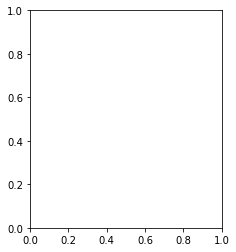

In [91]:
test(model)

In [23]:
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)


In [24]:
def lr_schedule(epoch, lr):
    if (epoch+1) % 5 == 0:
        lr = lr*0.8
    return max(lr, 0.0000003)

In [25]:
history = model.fit(
    data_generator(),
    epochs = 50,
    steps_per_epoch = 500,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='box_out_loss', patience=20, mode='min'),
        tf.keras.callbacks.LearningRateScheduler(lr_schedule),
        ShowTestImages()
    ]
)

Output hidden; open in https://colab.research.google.com to view.

In [26]:
history = model.history
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'class_out_loss', 'box_out_loss', 'class_out_accuracy', 'box_out_iou', 'lr'])


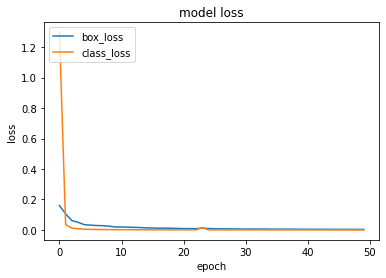

In [27]:
# summarize history for loss
plt.plot(history.history['box_out_loss'])
plt.plot(history.history['class_out_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['box_loss', 'class_loss'], loc='upper left')
plt.show()

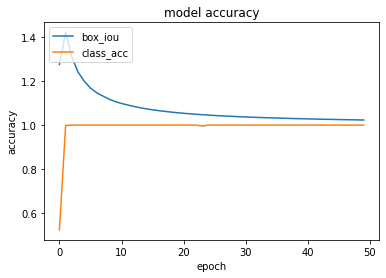

In [28]:
# summarize history for loss
plt.plot(history.history['box_out_iou'])
plt.plot(history.history['class_out_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['box_iou', 'class_acc'], loc='upper left')
plt.show()

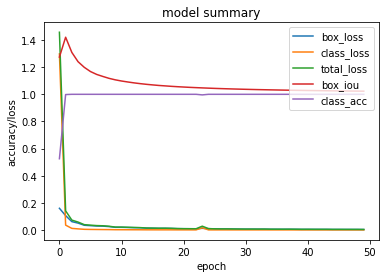

In [30]:
# summarize history for loss
plt.plot(history.history['box_out_loss'])
plt.plot(history.history['class_out_loss'])
plt.plot(history.history['loss'])
plt.plot(history.history['box_out_iou'])
plt.plot(history.history['class_out_accuracy'])
plt.title('model summary')
plt.ylabel('accuracy/loss')
plt.xlabel('epoch')
plt.legend(['box_loss', 'class_loss', 'total_loss', 'box_iou', 'class_acc'], loc='upper right')
plt.show()

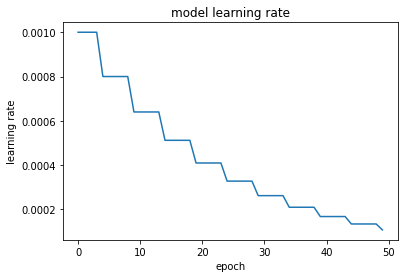

In [31]:
plt.plot(history.history['lr'])
plt.title('model learning rate')
plt.ylabel('learning rate')
plt.xlabel('epoch')
# plt.legend(['box_loss', 'class_loss', 'box_iou', 'class_acc'], loc='upper right')
plt.show()

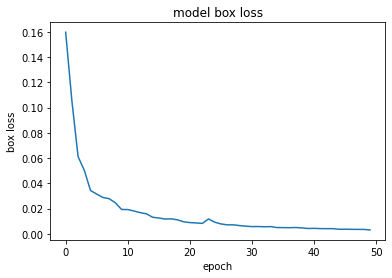

In [32]:
plt.plot(history.history['box_out_loss'])
plt.title('model box loss')
plt.ylabel('box loss')
plt.xlabel('epoch')
# plt.legend(['box_loss', 'class_loss', 'box_iou', 'class_acc'], loc='upper right')
plt.show()

In [1]:
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)